In [284]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e8/sample_submission.csv
/kaggle/input/playground-series-s5e8/train.csv
/kaggle/input/playground-series-s5e8/test.csv


# Imports

In [314]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from scipy.stats import chi2_contingency

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder, PowerTransformer
from sklearn.impute import SimpleImputer

# Model imports
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier

# Model evaluation imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

In [286]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [287]:
train = pd.read_csv("/kaggle/input/playground-series-s5e8/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e8/test.csv")
sample_submission = pd.read_csv("/kaggle/input/playground-series-s5e8/sample_submission.csv")

# Phase1: Data Understanding & Preparation

In [288]:
train.drop(columns=['id'], inplace=True)
train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,married,secondary,no,7,no,no,cellular,25,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,no,514,no,no,unknown,18,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,no,602,yes,no,unknown,14,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,no,34,yes,no,unknown,28,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,no,889,yes,no,cellular,3,feb,902,1,-1,0,unknown,1


## 1) Inspecting Structure

In [289]:
print(f'''no of rows: {train.shape[0]}
no of columns: {train.shape[1]}''')

no of rows: 750000
no of columns: 17


In [290]:
train.duplicated().sum()

0

In [291]:
train.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

## 2) Exploratory Data Analysis

### 1. Target Feature

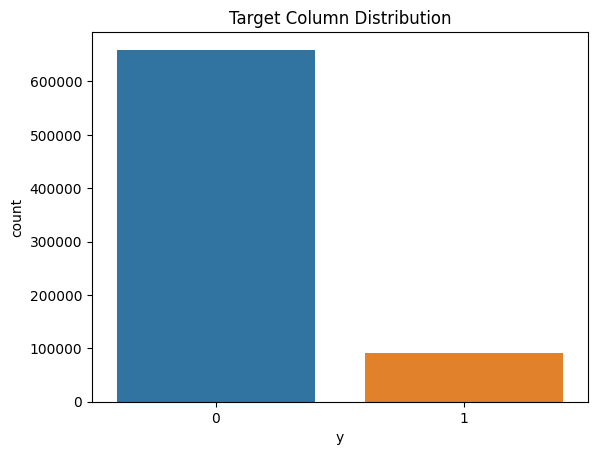

In [292]:
sns.countplot(x='y', data=train)
plt.title("Target Column Distribution")
plt.show()

### 2. Categorical Features

#### Checking Distributions:

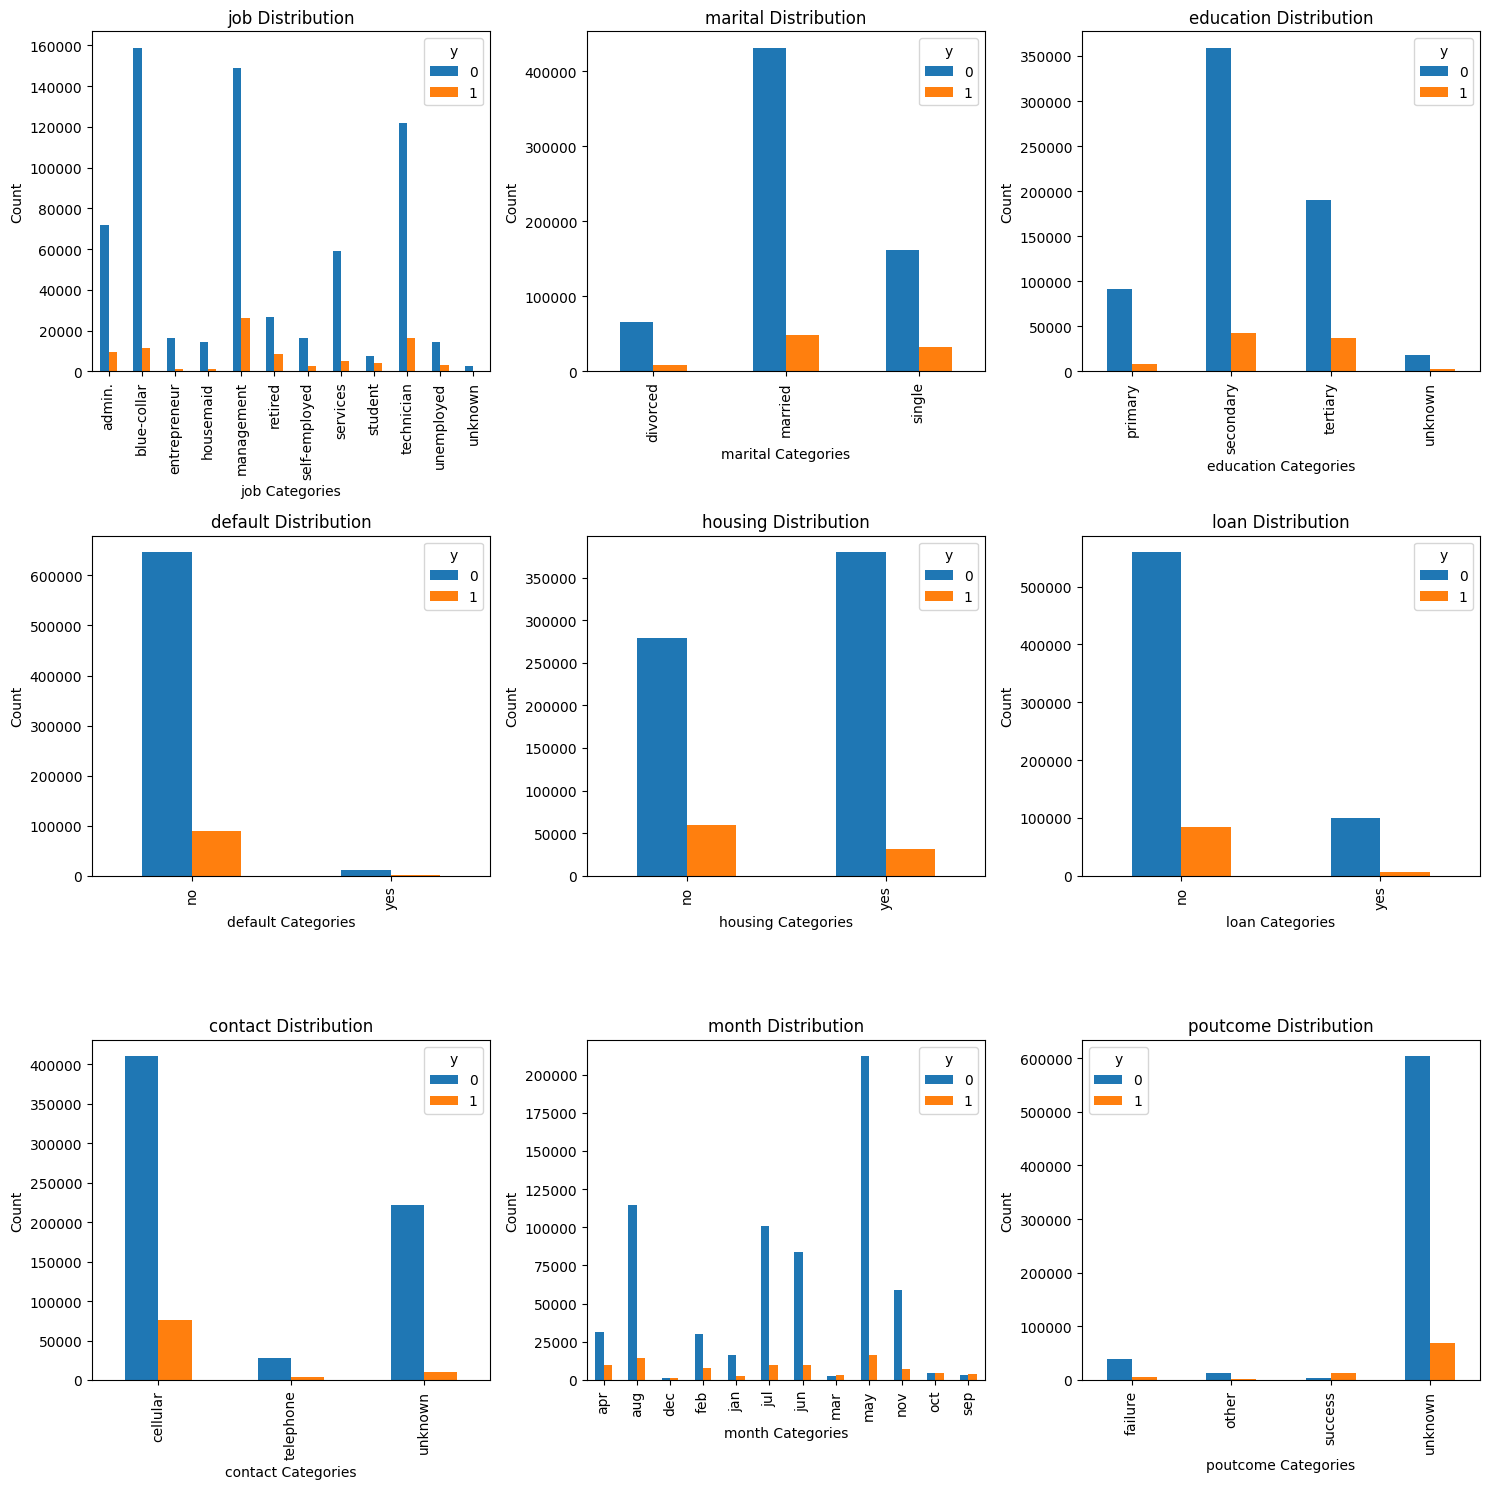

In [293]:
categoricals = train.select_dtypes(include=['object']).columns

n_cols = 3
n_rows = (len(categoricals) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()

for i, col in enumerate(categoricals):
    ct = pd.crosstab(train[col], train['y']).plot(kind='bar', ax=axes[i])
    axes[i].set_title(f'{col} Distribution')
    axes[i].set_xlabel(f"{col} Categories")
    axes[i].set_ylabel("Count")

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### 2. Checking feature importance and colinearity

In [294]:
def cramers_v(x, y):
    """
    Cramer's V statistic for categorical-categorical association
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape

    # Bias correction
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cramers_results = {}
for col in categoricals:
    cramers_results[col] = cramers_v(train[col], train['y'])

cramers_df = pd.DataFrame.from_dict(cramers_results, orient='index', columns=['Cramers_V'])
print(cramers_df.sort_values(by='Cramers_V', ascending=False))

           Cramers_V
poutcome    0.308984
month       0.263997
contact     0.159905
job         0.157259
housing     0.153581
marital     0.090983
education   0.089479
loan        0.081625
default     0.030096


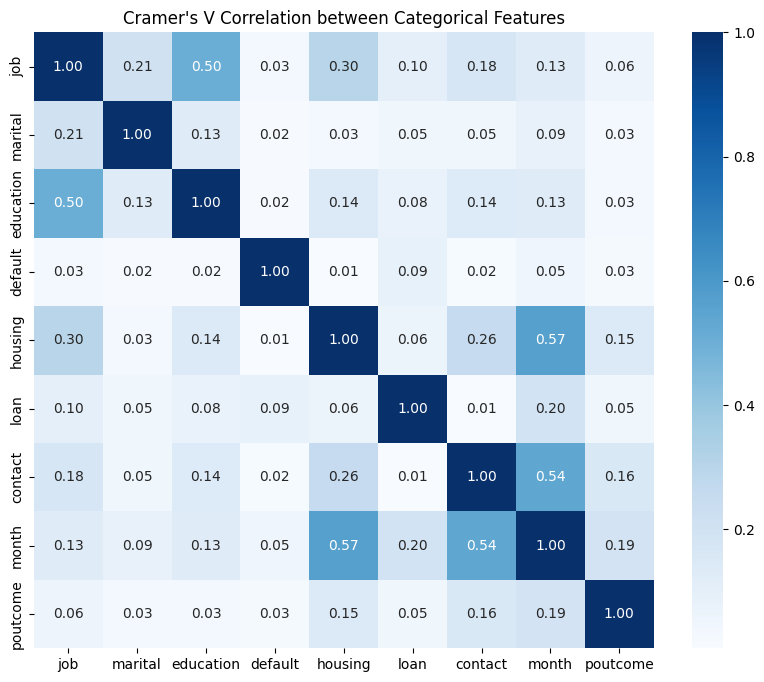

In [295]:
# Pairwise Cramér’s V
cramers_matrix = pd.DataFrame(
    np.zeros((len(categoricals), len(categoricals))),
    index=categoricals,
    columns=categoricals
)

for col1 in categoricals:
    for col2 in categoricals:
        if col1 == col2:
            cramers_matrix.loc[col1, col2] = 1.0  # self-correlation
        else:
            cramers_matrix.loc[col1, col2] = cramers_v(train[col1], train[col2])

plt.figure(figsize=(10,8))
sns.heatmap(cramers_matrix, annot=True, fmt=".2f", cmap="Blues")
plt.title("Cramer's V Correlation between Categorical Features")
plt.show()

> Since `default` feature carry almost no prediction power + has a very weak correlation with all features, it is better be dropped for simplicity

In [296]:
train.drop(columns='default', inplace=True)

### 3) Numerical Features 

#### 1. Checking Distribution

In [297]:
train.describe()

,age,balance,day,duration,campaign,pdays,previous,y
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,40.926395,1204.067397,16.117209,256.229144,2.577008,22.412733,0.298545,0.120651
std,10.098829,2836.096759,8.250832,272.555662,2.718514,77.319998,1.335926,0.325721
min,18.000000,-8019.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,9.000000,91.000000,1.000000,-1.000000,0.000000,0.000000
50%,39.000000,634.000000,17.000000,133.000000,2.000000,-1.000000,0.000000,0.000000
75%,48.000000,1390.000000,21.000000,361.000000,3.000000,-1.000000,0.000000,0.000000
max,95.000000,99717.000000,31.000000,4918.000000,63.000000,871.000000,200.000000,1.000000


> Since Day as a column is less likely to have any predictive power over the target, it is better be dropped (esp since data has already a month category)

In [298]:
train.drop(columns='day', inplace=True)

Ensuring Data Quality & Consistency

In [299]:
# Case 1: previous = 0 but pdays != -1
invalid_case1 = train[(train['previous'] == 0) & (train['pdays'] != -1)]

# Case 2: previous > 0 but pdays == -1
invalid_case2 = train[(train['previous'] > 0) & (train['pdays'] == -1)]

print("Case 1 violations:", len(invalid_case1))
print("Case 2 violations:", len(invalid_case2))

Case 1 violations: 14
Case 2 violations: 17


In [300]:
train = train.drop(invalid_case1.index.union(invalid_case2.index))

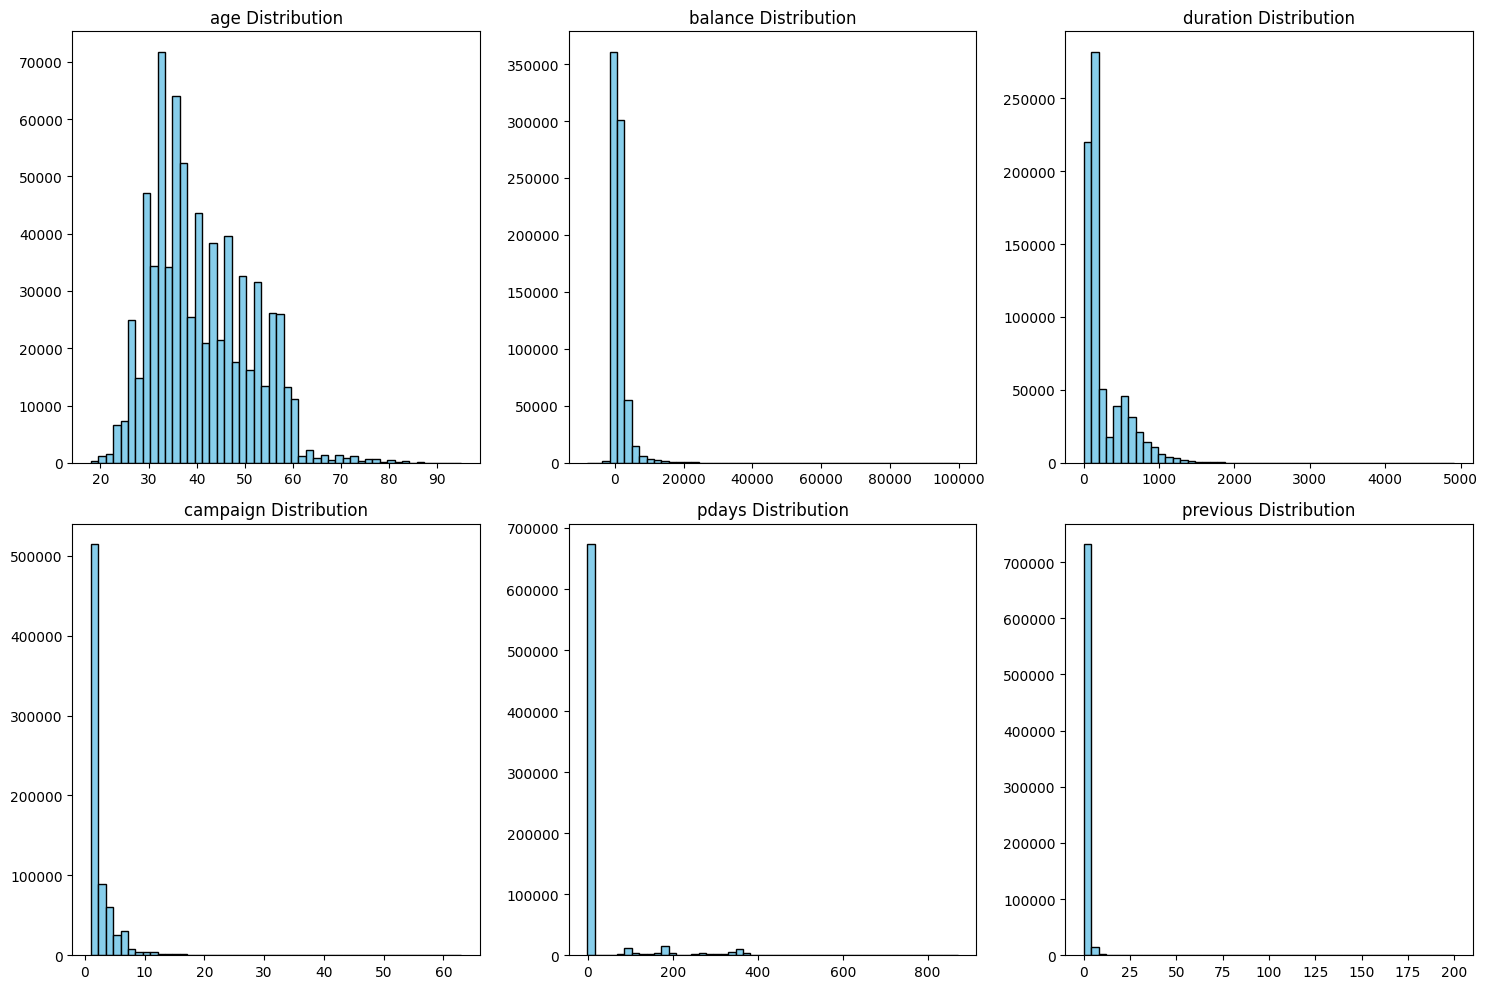

In [301]:
numericals = train.select_dtypes(include=['int64', 'float64']).columns.drop('y','pdays_never')

batch_size = 6 # how many features per figure

for start in range(0, len(numericals), batch_size):
    subset = numericals[start:start+batch_size]
    n_cols = 3
    n_rows = (len(subset) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(subset):
        axes[i].hist(train[col], bins=50, color='skyblue', edgecolor='black')
        axes[i].set_title(f'{col} Distribution')
    
    # to remove extra axes
    for j in range(len(subset), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

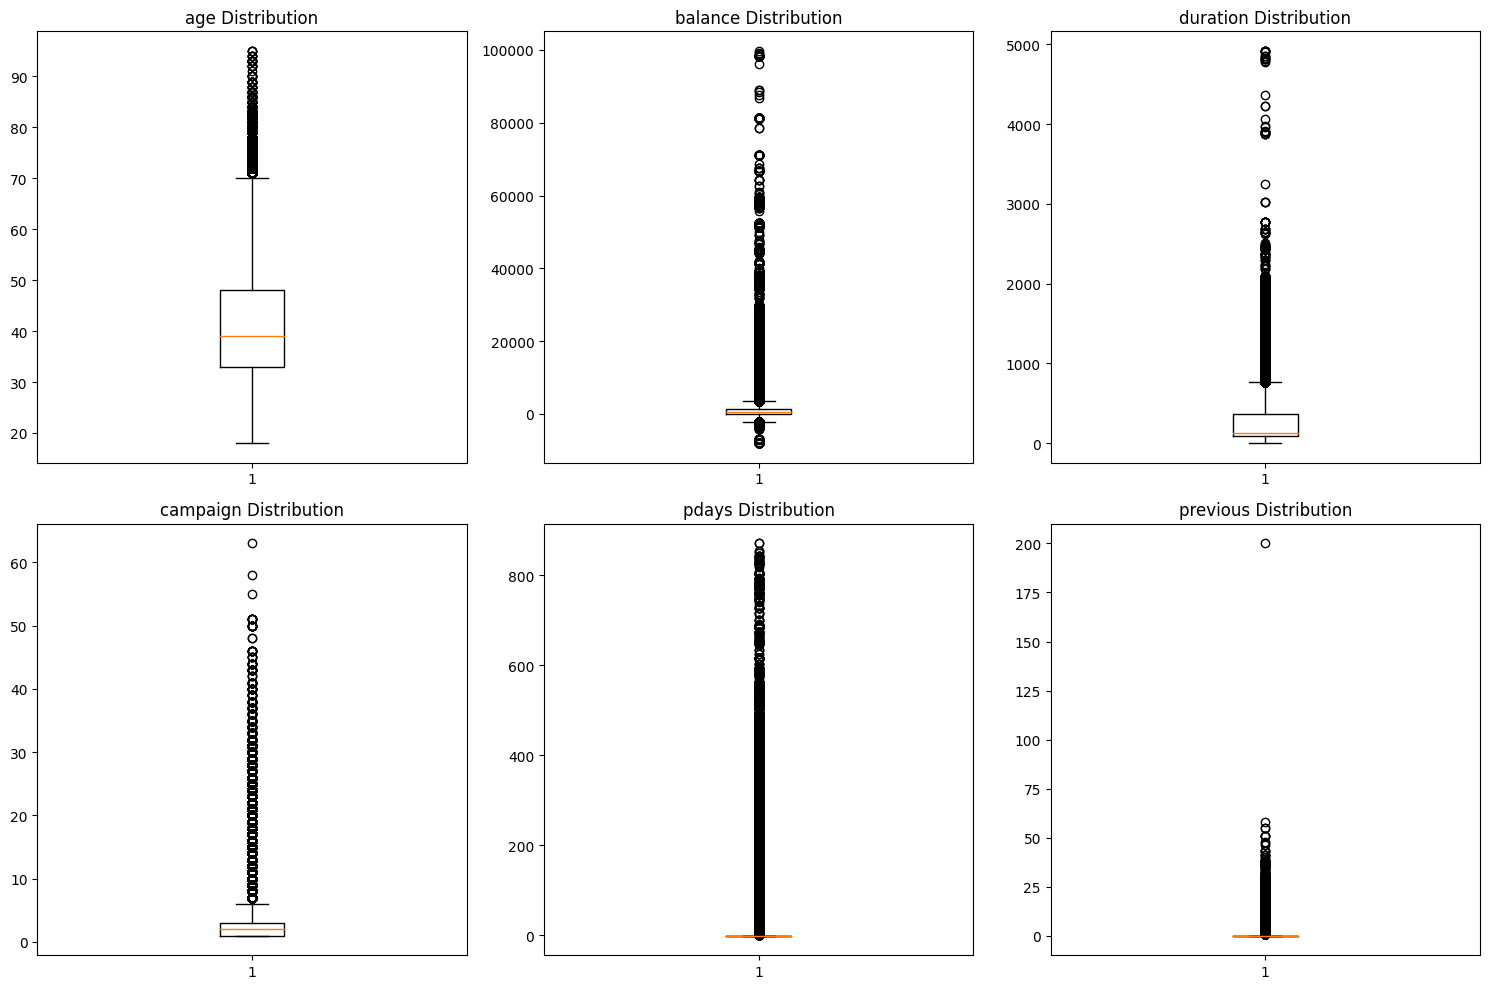

In [302]:
batch_size = 6  

for start in range(0, len(numericals), batch_size):
    subset = numericals[start:start+batch_size]
    n_cols = 3
    n_rows = (len(subset) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten()
    
    for i, col in enumerate(subset):
        axes[i].boxplot(train[col])
        axes[i].set_title(f'{col} Distribution')
    
    for j in range(len(subset), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

### 2. Correlation

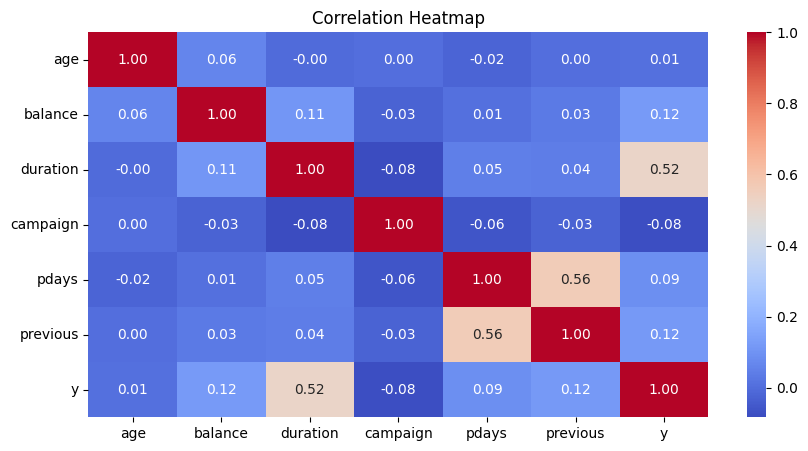

In [303]:
correlation = train.corr(numeric_only=True)

plt.figure(figsize=(10,5))
sns.heatmap(correlation, annot=True , fmt= '.2f', cmap= 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()

----

# Phase 2: pre-processing and splitting

In [306]:
train

,age,job,marital,education,balance,housing,loan,contact,month,duration,campaign,pdays,previous,poutcome,y
0,42,technician,married,secondary,7,no,no,cellular,aug,117,3,-1,0,unknown,0
1,38,blue-collar,married,secondary,514,no,no,unknown,jun,185,1,-1,0,unknown,0
2,36,blue-collar,married,secondary,602,yes,no,unknown,may,111,2,-1,0,unknown,0
3,27,student,single,secondary,34,yes,no,unknown,may,10,2,-1,0,unknown,0
4,26,technician,married,secondary,889,yes,no,cellular,feb,902,1,-1,0,unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,29,services,single,secondary,1282,no,yes,unknown,jul,1006,2,-1,0,unknown,1
749996,69,retired,divorced,tertiary,631,no,no,cellular,aug,87,1,-1,0,unknown,0
749997,50,blue-collar,married,secondary,217,yes,no,cellular,apr,113,1,-1,0,unknown,0
749998,32,technician,married,secondary,-274,no,no,cellular,aug,108,6,-1,0,unknown,0


In [307]:
X = train.drop(columns=['y'])
y = train['y']

# Using stratify=y to ensure the class distribution is preserved in both sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [308]:
# Replace "unknown" with NaN in job and education
X_train['job'] = X_train['job'].replace("unknown", np.nan)
X_val['job']   = X_val['job'].replace("unknown", np.nan)

X_train['education'] = X_train['education'].replace("unknown", np.nan)
X_val['education']   = X_val['education'].replace("unknown", np.nan)

In [309]:
# calculating flag `pdays_never`
X_train['pdays_never'] = (X_train['pdays'] == -1).astype(int)
X_val['pdays_never'] = (X_val['pdays'] == -1).astype(int)

X_train['pdays'] = X_train['pdays'].replace(-1, np.nan)
X_val['pdays'] = X_val['pdays'].replace(-1, np.nan)

## 1) linear Preprocessing Object

In [310]:
from sklearn.base import BaseEstimator, TransformerMixin

class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower=0.01, upper=0.99):
        self.lower = lower
        self.upper = upper
    
    def fit(self, X, y=None):
        # storing percentiles from training data
        self.lower_bounds = np.percentile(X, self.lower * 100, axis=0)
        self.upper_bounds = np.percentile(X, self.upper * 100, axis=0)
        return self
    
    def transform(self, X):
        # applying capping
        return np.clip(X, self.lower_bounds, self.upper_bounds)

In [311]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

onehot_cols = ["job", "poutcome", "marital"]
ordinal_edu = ["education"]
ordinal_mon = ["month"]
label_cols = ["housing", "loan"]

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

complex_transform_cols = ["balance", "duration", "campaign", "previous"]
simple_num_cols = [c for c in num_cols if c not in complex_transform_cols]

# transformations
onehot_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(drop="first", handle_unknown="ignore"))
])

ordinal_edu_mapping = [["primary", "secondary", "tertiary"]] 
ordinal_edu_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(categories=ordinal_edu_mapping))
])

ordinal_mon_mapping = [["jan","feb","mar","apr","may","jun",
        "jul","aug","sep","oct","nov","dec"]] 
ordinal_mon_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(categories=ordinal_mon_mapping))
])

label_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

complex_num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("winsor", Winsorizer(lower=0.01, upper=0.99)),
    ("power", PowerTransformer(method='yeo-johnson')),   # handles zero/negative
    ("scaler", RobustScaler())
])

simple_num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", RobustScaler())
])

# ColumnTransformer
linear_preprocessor = ColumnTransformer(
    transformers=[
        ("onehot", onehot_transformer, onehot_cols),
        ("ordinal_edu", ordinal_edu_transformer, ordinal_edu),
        ("ordinal_mon", ordinal_mon_transformer, ordinal_mon),
        ("label", label_transformer, label_cols),
        ("complex_num", complex_num_transformer, complex_transform_cols),
        ("simple_num", simple_num_transformer, simple_num_cols)
    ],
    remainder="drop"
)

## 2) Tree Preprocessing Object

In [312]:
ordinal_edu = ["education"]
ordinal_mon = ["month"]
label_cols = ["housing", "loan", "job", "poutcome", "marital"]

num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# transformations
ordinal_edu_mapping = [["primary", "secondary", "tertiary"]] 
ordinal_edu_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(categories=ordinal_edu_mapping))
])

ordinal_mon_mapping = [["jan","feb","mar","apr","may","jun",
        "jul","aug","sep","oct","nov","dec"]] 
ordinal_mon_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(categories=ordinal_mon_mapping))
])

label_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("winsor", Winsorizer(lower=0.01, upper=0.99)),
])

# ColumnTransformer
tree_preprocessor = ColumnTransformer(
    transformers=[
        ("ordinal_edu", ordinal_edu_transformer, ordinal_edu),
        ("ordinal_mon", ordinal_mon_transformer, ordinal_mon),
        ("label", label_transformer, label_cols),
        ("num", num_transformer, num_cols),
    ],
    remainder="drop"
)

------

# Phase 3: Modelling & Tuning

In [320]:
models = {
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000, solver='lbfgs'),
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced')
}

results = {}

for model_name, model in models.items():
    print(f"\n{'-'*50}")
    print(f"Training {model_name}")
    print(f"{'-'*50}")

    # Choosing appropriate preprocessor
    if model_name == 'Logistic Regression':
        preprocessor = linear_preprocessor
    else:  
        preprocessor = tree_preprocessor

    # Create pipeline (use consistent variable name)
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])  

    # Training the model 
    pipeline.fit(X_train, y_train)  

    # Predictions
    y_pred = pipeline.predict(X_val)  
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1] if hasattr(pipeline, 'predict_proba') else None 

    # Evaluation
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))
    print()

    results[model_name] = {
        'pipeline': pipeline,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy_score(y_val, y_pred)
    }


--------------------------------------------------
Training Logistic Regression
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.84      0.91    131897
           1       0.43      0.89      0.58     18097

    accuracy                           0.85    149994
   macro avg       0.71      0.86      0.74    149994
weighted avg       0.92      0.85      0.87    149994

Confusion Matrix:
[[110822  21075]
 [  2043  16054]]


--------------------------------------------------
Training Random Forest
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96    131897
           1       0.75      0.59      0.66     18097

    accuracy                           0.93    149994
   macro avg       0.85      0.78      0.81    149994
weighted avg       0.92      0.93      0.

---------

> Since the Tree-based Model performed better than the linear model, we will stick to tree models

In [324]:
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

neg, pos = np.bincount(y_train)
scale = neg / pos

# Trying more complex tree models 
complex_tree_models = {
    "XGBoost": XGBClassifier(
        random_state=42,
        use_label_encoder=False,
        eval_metric="logloss",
        scale_pos_weight=scale   # increases the weight of the minority class
    ),
    "LightGBM": LGBMClassifier(
        random_state=42,
        class_weight='balanced'
    ),
    "CatBoost": CatBoostClassifier(
        random_state=42,
        verbose=0,
        class_weights=[1, neg/pos]  # # minority class gets higher weight
    )
}

for model_name, model in complex_tree_models.items():

    print(f"\n{'-'*50}")
    print(f"Training {model_name}")
    print(f"{'-'*50}")

    pipeline = Pipeline([
        ('preprocessor', tree_preprocessor),
        ('classifier', model)
    ])  

    # Training the model 
    pipeline.fit(X_train, y_train)  

    # Predictions
    y_pred = pipeline.predict(X_val)  
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1] if hasattr(pipeline, 'predict_proba') else None 

    # Evaluation
    print("\nClassification Report:")
    print(classification_report(y_val, y_pred))
    
    print("Confusion Matrix:")
    print(confusion_matrix(y_val, y_pred))
    print()

    results[model_name] = {
        'pipeline': pipeline,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba,
        'accuracy': accuracy_score(y_val, y_pred)
    }


--------------------------------------------------
Training XGBoost
--------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.87      0.92    131897
           1       0.49      0.93      0.64     18097

    accuracy                           0.87    149994
   macro avg       0.74      0.90      0.78    149994
weighted avg       0.93      0.87      0.89    149994

Confusion Matrix:
[[114313  17584]
 [  1285  16812]]


--------------------------------------------------
Training LightGBM
--------------------------------------------------
[LightGBM] [Info] Number of positive: 72388, number of negative: 527587
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 779
[LightGBM] [Info] Numbe

In [328]:
# Compute scale_pos_weight for XGBoost / class_weights
neg, pos = np.bincount(y_train)
scale = neg / pos

xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
    scale_pos_weight=scale
)

lgb_model = LGBMClassifier(
    random_state=42,
    class_weight='balanced'
)

cat_model = CatBoostClassifier(
    random_state=42,
    verbose=0,
    class_weights=[1, scale]  # minority class weighted
)

In [329]:
from sklearn.pipeline import Pipeline

xgb_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', xgb_model)
])

lgb_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', lgb_model)
])

cat_pipeline = Pipeline([
    ('preprocessor', tree_preprocessor),
    ('classifier', cat_model)
])


# Phase 4 : Tuning Best Performer & Final Evaluation

In [ ]:
#y_proba = dummy.predict_proba(test.drop(columns=["id"]))[:,1]

In [ ]:
#submission = pd.DataFrame()

#submission['id'] = test['id']
#submission['y'] = y_proba

In [ ]:
#submission.to_csv("submission.csv", index=False)